# Accès aux interfaces numériques 
## Taux de pauvreté - données 2019

Source :   Base de données - IRCOM

### Taux demandeurs d'emploi rempli avec la medianne

In [1]:
import os 
from glob import glob
import pandas as pd
import numpy as np
import xlrd
import matplotlib.pyplot as plt

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

external_data = Path('../data/external/')
processed_data = Path('../data/processed/')
raw_data = Path('../data/raw/')
interim_data = Path('../data/interim/')

In [19]:
#!pip install xlrd

     |████████████████████████████████| 103 kB 427 kB/s eta 0:00:01


### 1. Créer un dataframe à partir de fichiers xls


In [2]:
list_files= glob(os.path.join(raw_data/'Donnees_indices_fragilites_numeriques','**/**/2019/*.xls'))
list_files[0]

'../data/raw/Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/2A - Corse du Sud.xls'

Fichiers récupérés sur les revenus de l'IRCOM 2018. Un dossier par commune. La méthode `create_dataframe` permet d'extraire le tableau qui commence à la ligne 23, on prend le premiers 6 colonnes.  
* columns : les noms du dataframe
* start_row : ligne qui contient le entête du tableau

In [3]:
def create_dataframe(filename,columns = ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal'],start_row=23,start_col=1,end_col = 6):
    # load the first sheet
    wb = xlrd.open_workbook(filename=filename)
    sheet = wb.sheet_by_index(0)   
    data = [sheet.row_values(i,start_colx=start_col,end_colx=end_col) for i in range(start_row,sheet.nrows)]  # get the info
    df = pd.DataFrame(data,columns=columns)
    df['Dep'] = df['Dep'].transform(lambda x: x[:2]) #convert 060 to 06 (departement)
    return df

In [4]:
# Example 
df = create_dataframe(list_files[7])
df.head()

,Dep,Commune,Libelle,revenu_fiscal_ref,num_foyers_fiscal
0,06,001,Aiglun,Total,49
1,06,002,Amirat,Total,21
2,06,003,Andon,Total,348
3,06,004,Antibes,0 à 10 000,10235
4,06,004,Antibes,10 001 à 12 000,2526


### 2. Creation d'un tableau croisé à partir de `revenu_fiscal_ref'


In [8]:
# Trouver l'index avec le nom du departement, le fichier 0 et 30 contient 'Corse' dans le nom de fichier
for i,c in enumerate(list_files):
    if 'Corse' in c:
        print(i)

0
30


## Taux de pauvreté

On prend le nombre de foyers fiscaux où le revenu fiscal de référence par tranche (en euros) est entre 0 à 10 000 et 10 001 à 12 000. Le taux de pauvreté d'une commune correspond à la somme des ces foyers sur le total. Le taux et calculé en pourcentage et le code INSEE est l'index du tableu (code DEP+code COMMUNE), 5 chiffres. 

`TX_POVERTY = (number_foyers10k + number_foyers12k) / total`


In [5]:
def get_data(file):
    # 1. create dataframe from excel : ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal']
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum).reset_index()
    # ----- calculating indices
    # n.c. to Nan  num_foyers < 12 000 ()
    table.loc[table['0 à 10 000'] == 'n.c.','0 à 10 000'] = np.nan
    table.loc[table['10 001 à 12 000']  == 'n.c.', '10 001 à 12 000'] = np.nan
    table.loc[table['Total']  == 'n.c.','Total'] = np.nan
    
    # TX_POVERTY = (number_foyers10k + number_foyers12k) / total
    taux = []
    for foyers_10k,foyers_12k,total in zip(table['0 à 10 000'],table['10 001 à 12 000'],table['Total']):
        if foyers_10k != np.nan and foyers_12k != np.nan:
            taux.append(((foyers_10k + foyers_12k) / total) * 100)
        elif foyers_10k == np.nan:
            taux.append(((foyers_12k) / total) * 100)
        else:
            taux.append(((foyers_10k) / total) * 100)
            
    table['TX_POVERTY'] = taux
    table['CODE_INSEE'] = table['Dep'] + table['Commune']
    return table[['CODE_INSEE','TX_POVERTY']]
    

# Les valeurs manquantes

Lorsque le nombre de foyers est inférieur à 1000 ou que la commune a des valeurs 'n.c', il n'est pas possible de calculer une valeur exacte pour la commune, pour visualiser les valeurs manquantes nous utilisons les coordonnées gps de LaPoste avec le code INSEE. La derniere version [gps](https://www.datavis.fr/tech/validate-your-data/laposte_hexasmal_update.zip)

[Depot-LaPoste](https://datanova.legroupe.laposte.fr/explore/dataset/laposte_hexasmal/export/?disjunctive.code_commune_insee&disjunctive.nom_de_la_commune&disjunctive.code_postal&disjunctive.libell_d_acheminement&disjunctive.ligne_5&location=7,46.52863,2.86194&basemap=jawg.streets)

In [6]:
# Testing avec le département 06
dep06= get_data(list_files[7])
print(dep06.isna().sum())

revenu_fiscal_ref
CODE_INSEE      0
TX_POVERTY    103
dtype: int64


In [7]:
## testing with data_gps.
data_gps = pd.read_csv(external_data/'data_gps.csv')
data_gps['code_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in data_gps['code_INSEE']]
data_gps.columns = ['CODE_INSEE','latitude','longitude']

In [8]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data

,CODE_INSEE,TX_POVERTY,latitude,longitude
0,06001,NaN,43.852419,6.934942
1,06002,NaN,43.896297,6.812560
2,06003,NaN,43.776986,6.823186
3,06003,NaN,43.776986,6.823186
4,06004,24.384232,43.587465,7.106354
...,...,...,...,...
188,06160,NaN,44.122142,6.781905
189,06161,20.511134,43.649256,7.107284
190,06162,NaN,44.071456,7.651478
191,06163,39.257504,44.099767,7.540532


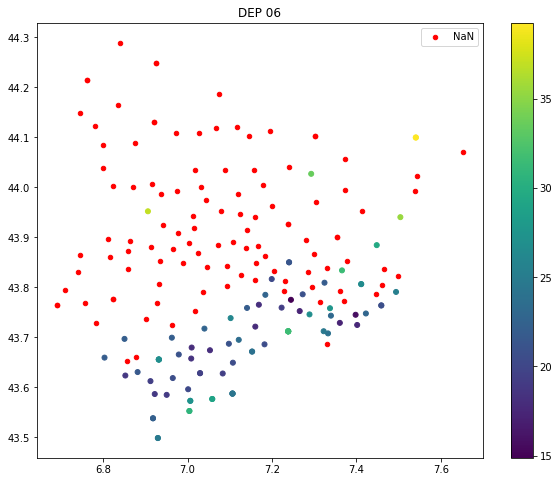

In [19]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data.head()
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20, label='NaN')
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=25)
plt.title('DEP 06')
plt.legend()
fig.colorbar(sc)
plt.show()

**Note**

On a rempli les valeurs manquantes avec le taux moyenne du département.

In [9]:
# COMMUNES
dataframe_total = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] ".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    dataframe_total = pd.concat([dataframe_total,df])


In [10]:
dataframe_total.isna().sum()

revenu_fiscal_ref
CODE_INSEE        0
TX_POVERTY    29642
dtype: int64

In [17]:
#dataframe_total.to_csv('../data/taux_pauvrete.csv',index=False)

## Nan rempli avec la medianne par département

In [21]:
dataframe_total_median = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] nan median".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_median = df.fillna(value=df.TX_POVERTY.median())
    dataframe_total_median = pd.concat([dataframe_total_median,df_median])


# Data viz

In [22]:
data = pd.merge(dataframe_total,data_gps,on='CODE_INSEE')
data_fill_median = pd.merge(dataframe_total_median,data_gps,on='CODE_INSEE')

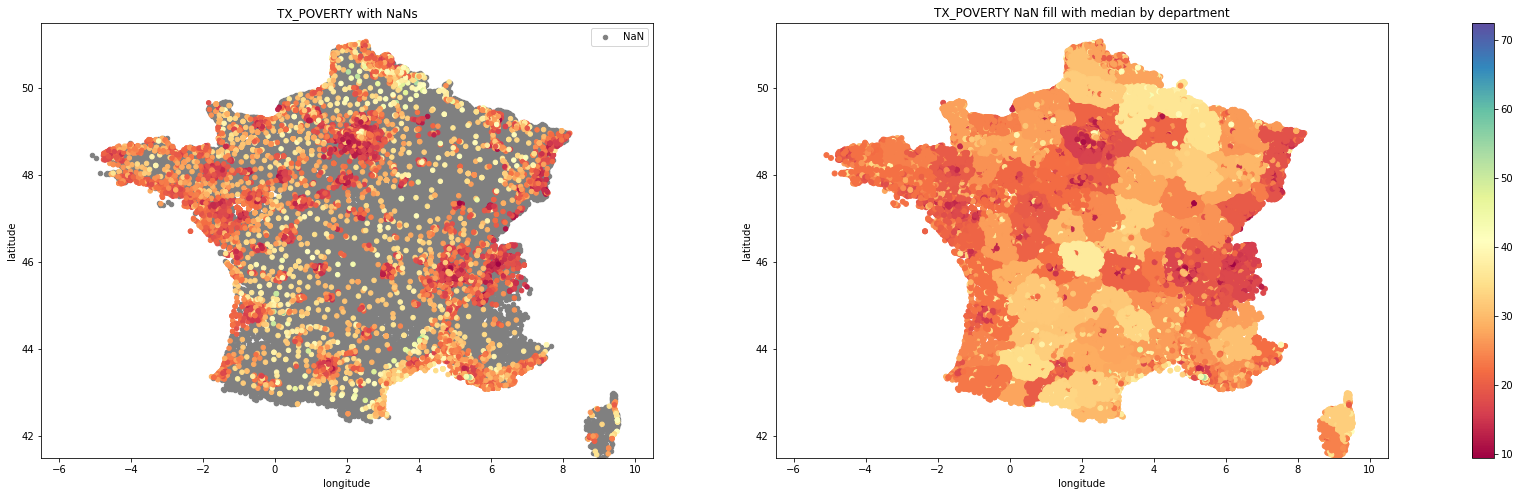

In [23]:
fig, ax = plt.subplots(1,2,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY with NaNs")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])
fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('tx_poverty.png', bbox_inches='tight')
plt.show()

In [24]:
print(dataframe_total_median.tail())

revenu_fiscal_ref CODE_INSEE  TX_POVERTY
421                    52546   32.358079
422                    52547   32.358079
423                    52548   32.358079
424                    52549   32.358079
425                    52550   33.152828


In [11]:
communes = pd.read_csv(external_data/'table_iris_insee_epci.csv')[['CODE_INSEE','LIBCOM']]
communes = communes.drop_duplicates(subset='CODE_INSEE')
print("INSEE ",communes.count())

INSEE  CODE_INSEE    35010
LIBCOM        35010
dtype: int64


### export TX_POVERTY

In [12]:
#export with NaNs
tx_nan = pd.merge(communes,dataframe_total,on='CODE_INSEE',how='left')
tx_nan.count()

CODE_INSEE    35010
LIBCOM        35010
TX_POVERTY     5611
dtype: int64

In [13]:
tx_nan.to_csv(f'{interim_data}/taux_pauvrete.csv',index=False)

In [31]:
# export without nans
tx = pd.merge(communes,dataframe_total_median,on='CODE_INSEE',how='left')
tx.count()

CODE_INSEE    35010
LIBCOM        35010
TX_POVERTY    35002
dtype: int64

In [32]:
tx.loc[tx.TX_POVERTY.isna(),:]

,CODE_INSEE,LIBCOM,TX_POVERTY
3108,09304,Suzan,NaN
4884,14666,Sannerville,NaN
20072,55039,Beaumont-en-Verdunois,NaN
20083,55050,Bezonvaux,NaN
20158,55139,Cumières-le-Mort-Homme,NaN
20201,55189,Fleury-devant-Douaumont,NaN
20238,55239,Haumont-près-Samogneux,NaN
20297,55307,Louvemont-Côte-du-Poivre,NaN


In [33]:
tx.to_csv(f'{interim_data}/taux_pauvrete.csv',index=False)

# 2. revision  demandeurs

In merge_v2 only 72 valeurs of tx_demandeurs appears. Problem in merge

same notebook cecile

In [14]:
demandeur_emplois = pd.read_csv(raw_data/'data_DEFM2019_com.csv', sep=";")
pop_active = pd.read_csv(raw_data/'base-cc-emploi-pop-active-2016_SHORT.csv')
pop_active2 = pd.read_csv(raw_data/'base-cc-emploi-pop-active-2016-COM.CSV', sep=";")
pop_active2 = pop_active2[['CODGEO', 'P16_ACT1564']]
pop_active = pop_active.append(pop_active2)
pop_active['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in pop_active['CODGEO']]
pop_active.head()

,CODGEO,P16_ACT1564
0,01001,376.000000
1,01002,123.000000
2,01004,6697.333122
3,01005,864.845592
4,01006,58.000000


In [15]:
pop_active.count()

CODGEO         35002
P16_ACT1564    35002
dtype: int64

In [16]:
demandeur_emplois['ABC_TOT'] = demandeur_emplois['ABC_25'] + demandeur_emplois['ABC_2649'] + demandeur_emplois['ABC_50']
demandeur_emplois['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in demandeur_emplois['CODGEO']]


In [17]:
demandeur_emplois[['CODGEO','ABC_TOT']].count()

CODGEO     1181
ABC_TOT    1180
dtype: int64

In [19]:
data_emploi = pd.merge(demandeur_emplois[['CODGEO','ABC_TOT']],pop_active,on='CODGEO',how='outer')
### calculate TX_DEMANDEURS
data_emploi['TX_DEMANDEUR_EMPLOIS'] = (data_emploi['ABC_TOT'] / data_emploi['P16_ACT1564'])*100
data_emploi.columns = ['CODE_INSEE','ABC_TOT','P16_ACT1564','TX_DEMANDEUR_EMPLOIS']
#print(data_emploi.head(),data_emploi.count())
data_emploi


,CODE_INSEE,ABC_TOT,P16_ACT1564,TX_DEMANDEUR_EMPLOIS
0,01004,1457.0,6697.333122,21.754928
1,01031,375.0,1646.324569,22.778012
2,01033,1470.0,8072.414366,18.210165
3,01034,784.0,3998.000000,19.609805
4,01053,4148.0,17702.022560,23.432351
...,...,...,...,...
34997,97424,NaN,2489.422247,NaN
34998,97501,NaN,299.000000,NaN
34999,97502,NaN,2835.000000,NaN
35000,97701,NaN,6453.636270,NaN


In [20]:
TX_DEMANDEUR_NAN = pd.merge(communes,data_emploi[['CODE_INSEE','TX_DEMANDEUR_EMPLOIS']],on='CODE_INSEE',how='left')
TX_DEMANDEUR_NAN

,CODE_INSEE,LIBCOM,TX_DEMANDEUR_EMPLOIS
0,01001,L'Abergement-Clémenciat,NaN
1,01002,L'Abergement-de-Varey,NaN
2,01004,Ambérieu-en-Bugey,21.754928
3,01005,Ambérieux-en-Dombes,NaN
4,01006,Ambléon,NaN
...,...,...,...
35005,97613,M'Tsangamouji,NaN
35006,97614,Ouangani,NaN
35007,97615,Pamandzi,NaN
35008,97616,Sada,NaN


In [21]:
#export with nans
TX_DEMANDEUR_NAN.to_csv(f'{interim_data}/taux_demandeurs_emploi.csv',index=False)

In [55]:
data_emploi_gps = pd.merge(TX_DEMANDEUR_NAN,data_gps,on='CODE_INSEE')
data_emploi_gps.head()

,CODE_INSEE,LIBCOM,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,01001,L'Abergement-Clémenciat,NaN,46.153426,4.926114
1,01002,L'Abergement-de-Varey,NaN,46.009188,5.428017
2,01004,Ambérieu-en-Bugey,21.754928,45.960848,5.372926
3,01005,Ambérieux-en-Dombes,NaN,45.996180,4.912273
4,01006,Ambléon,NaN,45.749499,5.594320


# method median by department

In [48]:
def fill_with_median(dataframe,column):
    # Get median by department
    df = dataframe.loc[:,['CODE_INSEE',column]]
    df['DEP'] = [str(X)[:2] for X in dataframe['CODE_INSEE']]
    TX_MEDIAN = df.groupby(['DEP']).median().reset_index()
    print("Example median",TX_MEDIAN.loc[0])
    
    # Fill with median
    df_total = pd.DataFrame(columns=['CODE_INSEE',column])
    for dep,median in zip(TX_MEDIAN.DEP,TX_MEDIAN[column]):
        df_department = df.loc[df.DEP == dep,['CODE_INSEE',column]].fillna(value=median)
        df_total = pd.concat([df_department,df_total])
        #print("Fill {} department".format(dep))
    return df_total

### Demandeurs avec la medianne

In [57]:
column = 'TX_DEMANDEUR_EMPLOIS'
TX_DEMANDEUR_FULL = fill_with_median(TX_DEMANDEUR_NAN,column)

Example median DEP                        01
TX_DEMANDEUR_EMPLOIS    18.91
Name: 0, dtype: object


In [58]:
TX_DEMANDEUR_FULL.count()

CODE_INSEE              35010
TX_DEMANDEUR_EMPLOIS    35010
dtype: int64

### + visualisation des données

In [61]:
demandeurs_fill_median = pd.merge(TX_DEMANDEUR_FULL,data_gps,on='CODE_INSEE')
demandeurs_fill_median.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,97101,38.966692,16.272779,-61.501704
1,97101,38.966692,16.272779,-61.501704
2,97102,38.966692,16.465561,-61.461671
3,97103,38.966692,16.251171,-61.592936
4,97104,38.966692,16.045514,-61.719296


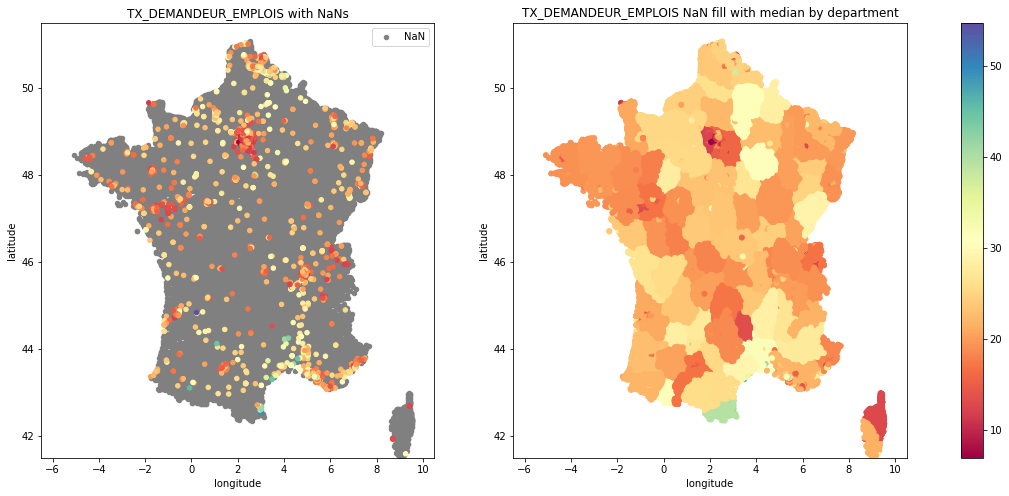

In [62]:
fig, ax = plt.subplots(1,2,figsize = (18,8))

data = data_emploi_gps
index = data.TX_DEMANDEUR_EMPLOIS.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_DEMANDEUR_EMPLOIS[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_DEMANDEUR_EMPLOIS with NaNs")
ax[0].legend()
sc = ax[1].scatter(demandeurs_fill_median.longitude,demandeurs_fill_median.latitude, c=demandeurs_fill_median.TX_DEMANDEUR_EMPLOIS, s=25,cmap='Spectral')
ax[1].set_title('TX_DEMANDEUR_EMPLOIS NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('TX_DEMANDEUR_EMPLOIS.png', bbox_inches='tight')
plt.show()

In [63]:
TX_DEMANDEUR_FULL

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS
34881,97101,38.966692
34882,97102,38.966692
34883,97103,38.966692
34884,97104,38.966692
34885,97105,38.966692
...,...,...
388,01452,18.909985
389,01453,18.909985
390,01454,18.909985
391,01456,18.909985


In [64]:
TX_DEMANDEUR_FULL.to_csv(f'{interim_data}/taux_demandeurs_emploi.csv',index=False)